# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
import glob

from torchvision import datasets, transforms
from src.models import training, linear_vanilla_vae, denoising_vanilla_vae

from src.features import utils
from src.features import dataLoader as MyDataLoader
import pathlib
import PIL
from torchvision.transforms import ToTensor, ToPILImage

from imageaugment import augment
import PIL.Image
import pathlib
import json

# Load MNIST

In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/raw/', train=True, transform=transforms.ToTensor()), batch_size=128, shuffle=True)

In [3]:
val_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/raw/', train=False, transform=transforms.ToTensor()), batch_size=32, shuffle=True)

## Get Mean & STD of the MNIST Data

In [15]:
dataset = datasets.MNIST('../../DivNoising/examples/data')
mean = 0.
std = 0.
for image, _ in dataset:
    mean += np.array(image).mean()
    std += np.array(image).std()

data_mean /= len(dataset)
data_std /= len(dataset)

# Load Simulated Patches

## Gaussian Noise Data

In [5]:
noisy_image_folder = pathlib.Path("/home/fahad/master_thesis/data/1024x1536/simulated_noisy_templates_with_gaussian_noise/")
x_train_tensor, x_val_tensor, mean, std = utils.load_image_tensor_patches(image_folder_path=noisy_image_folder, n_samples=1000)
print(x_train_tensor.shape)
print(x_val_tensor.shape)

torch.Size([64000, 1, 192, 128])
torch.Size([6400, 1, 192, 128])


## Simulated Noise Data

In [2]:
noisy_image_folder = pathlib.Path("/home/fahad/master_thesis/data/1024x1536/simulated_noisy_templates_without_gaussian_noise/")
x_train_tensor, x_val_tensor, mean, std = utils.load_image_tensor_patches(image_folder_path=noisy_image_folder, n_samples=1000)

print(x_train_tensor.shape)
print(x_val_tensor.shape)

torch.Size([64000, 1, 192, 128])
torch.Size([6400, 1, 192, 128])


## Load Crops

In [ ]:
def load_crops(crops_folder_path):
    crops_path_list = sorted(crops_folder_path.rglob("*.png"))

    crops = [ToTensor()(PIL.Image.open(crop_path)) for crop_path in crops_path_list]

    crops_tensor = torch.stack(crops)
    crops_tensor = crops_tensor.view(-1, 1, crops_tensor.size(2), crops_tensor.size(3))
    
    return crops_tensor

# Set Model Parameters

## Denoising Baseline

In [3]:
z_dim=64
in_channels = 1
init_filters = 32
n_filters_per_depth=2
n_depth=2
device = torch.device("cuda:0")

In [4]:
vae = denoising_vanilla_vae.VAE(z_dim=z_dim, in_channels=in_channels,init_filters = init_filters, n_filters_per_depth=n_filters_per_depth,n_depth=n_depth)

In [5]:
batch_size=512

train_dataset = MyDataLoader.MyDataset(x_train_tensor,x_train_tensor)
val_dataset = MyDataLoader.MyDataset(x_val_tensor,x_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

directory_path = "/home/fahad/master_thesis/vanilla_vae/models/unsupervised/Denoising_Baseline/patched_images/without_gaussian_noise/"
n_epochs = 300
net = vae
device = device

lr=0.001
val_loss_patience = 100
data_mean = mean.item()
data_std = std.item()
gaussian_noise_std = 1.0

model_name = "unsupervised_patched_64_dimensions-"

In [ ]:
trainHist, reconHistory, klHist, valHist = training.trainNetwork(net=net, train_loader=train_loader, 
                                                                 val_loader=val_loader,
                                                                 device=device,directory_path=directory_path,
                                                                 model_name=model_name,
                                                                 n_epochs=n_epochs, batch_size=batch_size,lr=lr,
                                                                 val_loss_patience = val_loss_patience,
                                                                 kl_annealing = True,
                                                                 kl_start = 0, 
                                                                 kl_annealtime = 3,
                                                                 data_mean =data_mean,data_std=data_std, 
                                                                 gaussian_noise_std = gaussian_noise_std)

## Vanilla VAE

In [5]:
batch_size=361
directory_path = "/home/fahad/master_thesis/vanilla_vae/models/"
n_epochs = 50
lr=0.001
model_name = "templates"

device = torch.device("cuda")
#device = torch.device("cpu")

In [8]:
"""
Initialize the network and the Adam optimizer
"""
net = MNIST_vae.VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(n_epochs):
    for clean_images, noisy_images in zip(train_clean_image_loader, train_noisy_image_loader):

        clean_images = clean_images.to(device)
        noisy_images = noisy_images.to(device)

        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(noisy_images)

        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = 0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, clean_images, reduction='sum') - kl_divergence
        #loss = torch.mean((out - data)**2) - kl_divergence

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {}: Loss {}'.format(epoch, loss))

Epoch 0: Loss 1494865.875
Epoch 1: Loss 1193066.5
Epoch 2: Loss 1075668.125
Epoch 3: Loss 1000020.8125
Epoch 4: Loss 942545.6875
Epoch 5: Loss 898492.4375
Epoch 6: Loss 863702.75
Epoch 7: Loss 810097.875
Epoch 8: Loss 770828.6875
Epoch 9: Loss 744506.125
Epoch 10: Loss 728036.0625
Epoch 11: Loss 710283.25
Epoch 12: Loss 699404.625
Epoch 13: Loss 698320.875
Epoch 14: Loss 710043.25
Epoch 15: Loss 678278.9375
Epoch 16: Loss 671177.75
Epoch 17: Loss 665495.4375
Epoch 18: Loss 660987.3125
Epoch 19: Loss 658890.0
Epoch 20: Loss 652735.4375
Epoch 21: Loss 651895.1875
Epoch 22: Loss 668961.875
Epoch 23: Loss 648052.25
Epoch 24: Loss 647698.625
Epoch 25: Loss 633314.5
Epoch 26: Loss 658843.75
Epoch 27: Loss 635607.6875
Epoch 28: Loss 632661.875
Epoch 29: Loss 629370.6875
Epoch 30: Loss 627629.9375
Epoch 31: Loss 631156.6875
Epoch 32: Loss 628507.25
Epoch 33: Loss 623547.375
Epoch 34: Loss 619008.75
Epoch 35: Loss 614365.5
Epoch 36: Loss 612252.4375
Epoch 37: Loss 610485.375
Epoch 38: Loss 6107

In [21]:
inputs = torch.rand(30,1,1024,1536)
mod1 = nn.Conv2d(1,16,5)
maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
mod2 = nn.Conv2d(16,32,5)
mod3 = nn.Conv2d(32, 64, 5)
out = maxpool(mod3(mod2(maxpool(mod1(inputs)))))
print(out.shape)

torch.Size([30, 64, 251, 379])


## Save Model

In [9]:
torch.save(net.state_dict(), "/home/fahad/master_thesis/vanilla_vae/models/net_modified.pth")

## Load Model

In [ ]:
net = vanilla_model.VAE().to(device)
net.load_state_dict(torch.load("/home/fahad/master_thesis/vanilla_vae/models/net_modified.pth"))

## Test Model

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
clean_image_list = []
noisy_image_list = []
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_noisy_image_loader), 1):
        imgs = data
        for i in range(batch_size):
            imgs = imgs.to(device)
            img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
            noisy_image_list.append(np.squeeze(img))
            out, mu, logVAR = net(imgs)
            outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
            clean_image_list.append(np.squeeze(outimg))

In [11]:
n = 19
clean_image_patches = []
noisy_image_patches = []

for i in range(n):
    clean_image_patches.append(np.concatenate(clean_image_list[i*n:(i+1)*n], axis=1))
    noisy_image_patches.append(np.concatenate(noisy_image_list[i*n:(i+1)*n], axis=1))

full_clean_image = np.concatenate(clean_image_patches, axis=0)
full_noisy_image = np.concatenate(noisy_image_patches, axis=0)

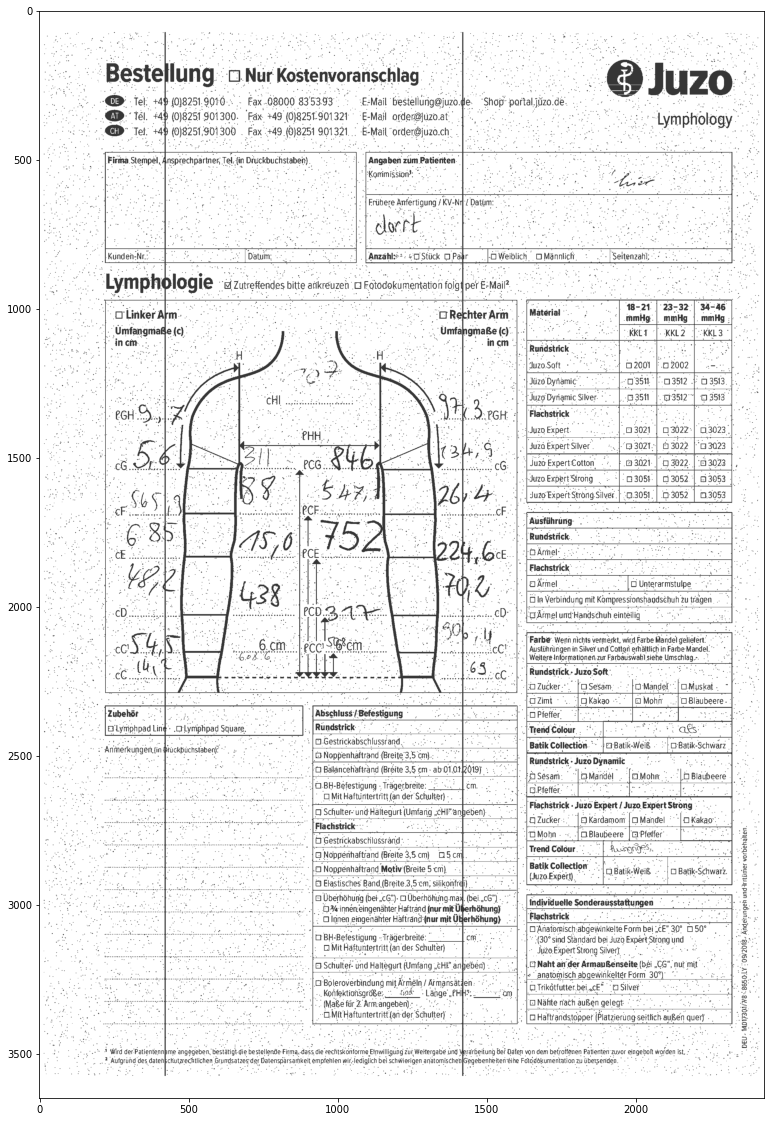

In [12]:
plt.figure(figsize=(30,20))
plt.imshow(full_noisy_image, cmap="gray")

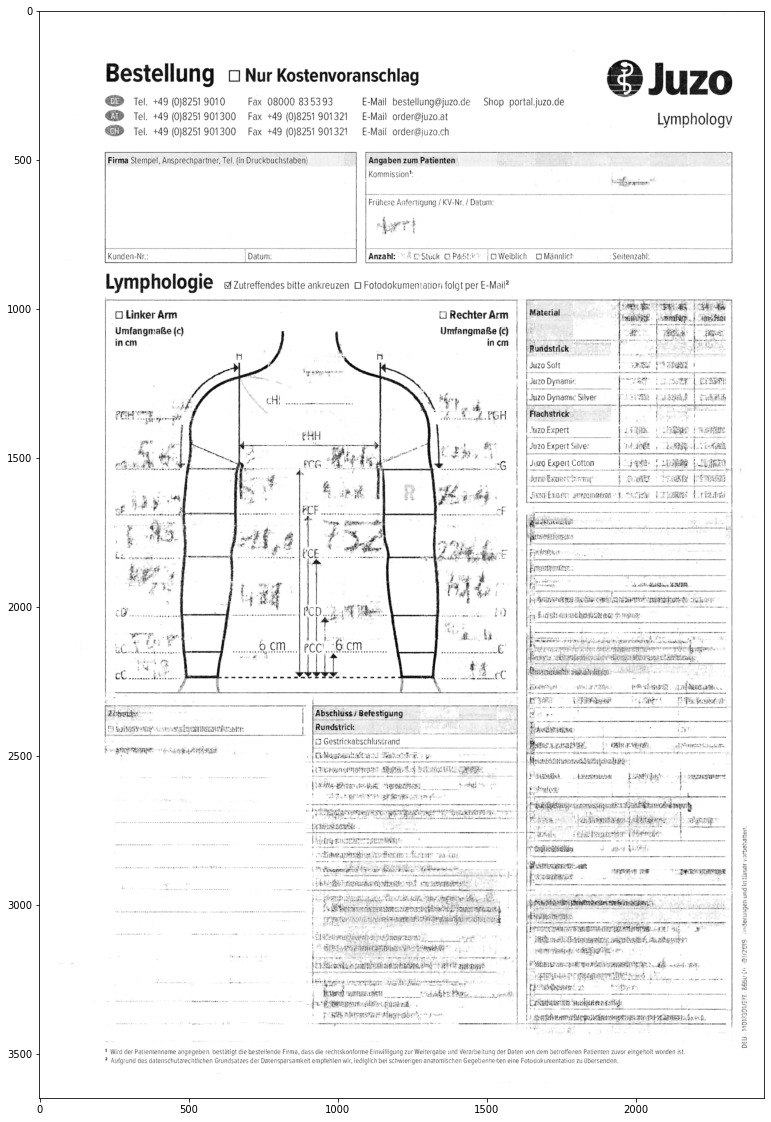

In [13]:
plt.figure(figsize=(30,20))
plt.imshow(full_clean_image, cmap="gray")

## Plot Input and Output

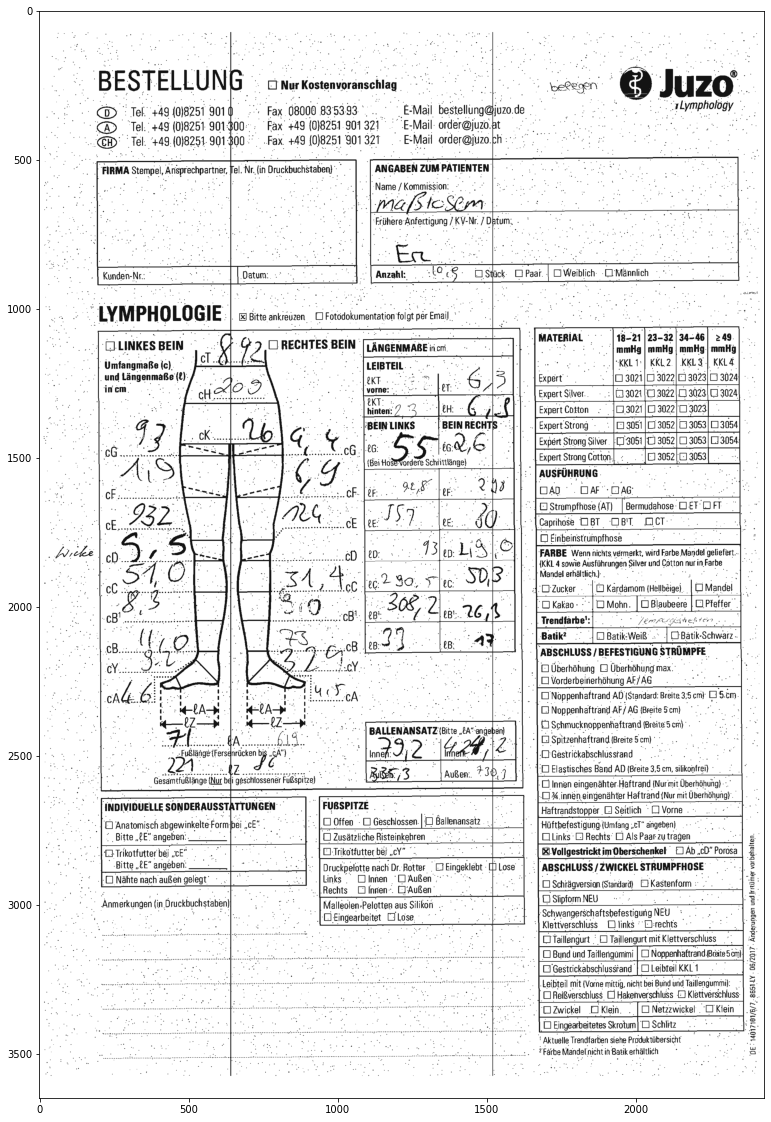

In [23]:
plt.figure(figsize=(30,20))
plt.imshow(full_noisy_image, cmap="gray")

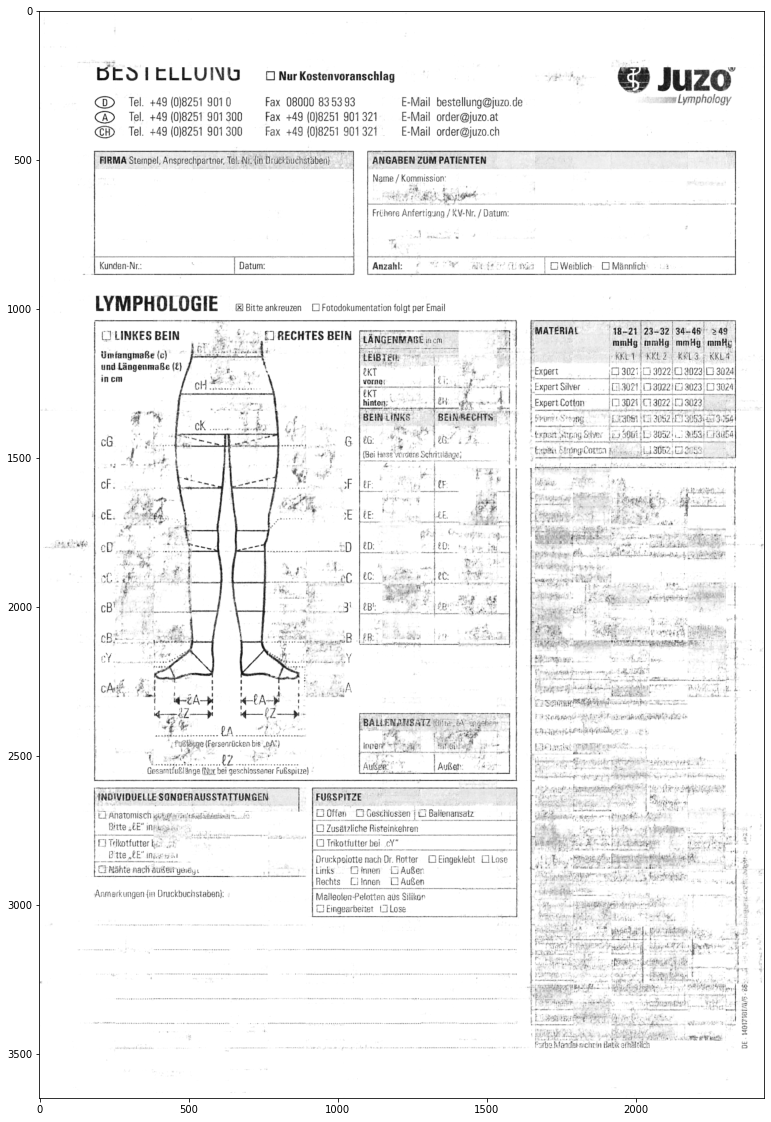

In [24]:
plt.figure(figsize=(30,20))
plt.imshow(full_clean_image, cmap="gray")